In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !curl https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -o dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


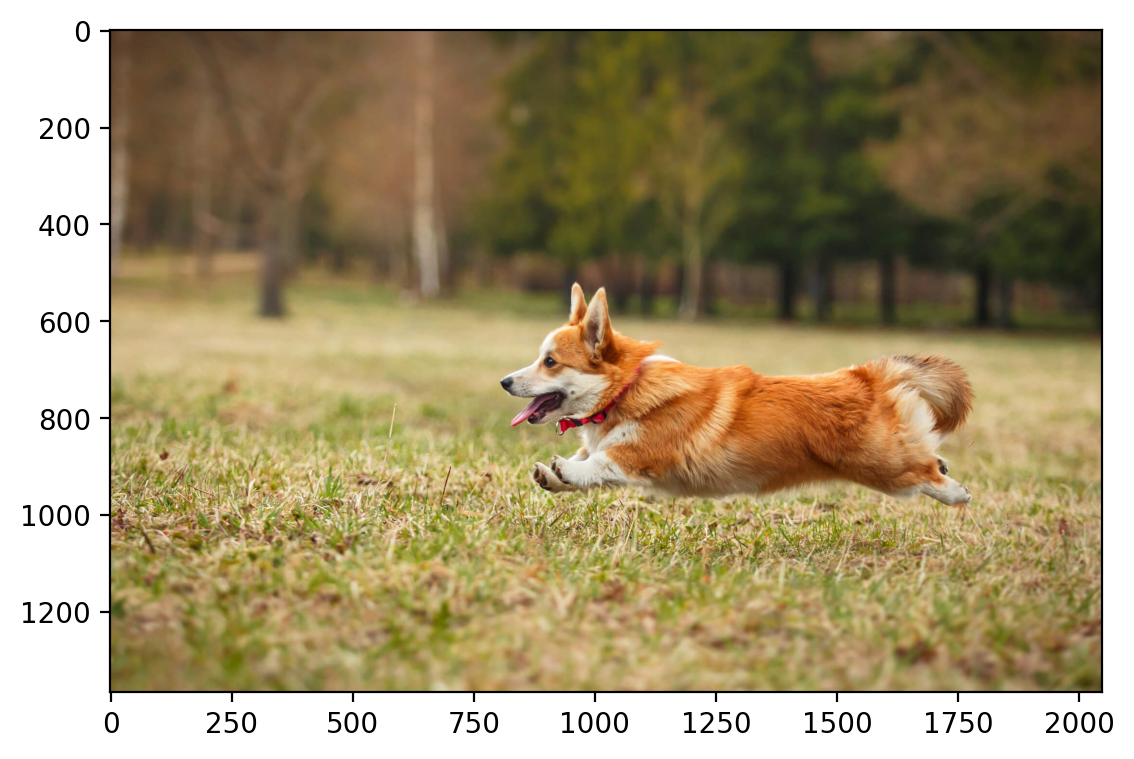

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

(3, 1365, 2048)


In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

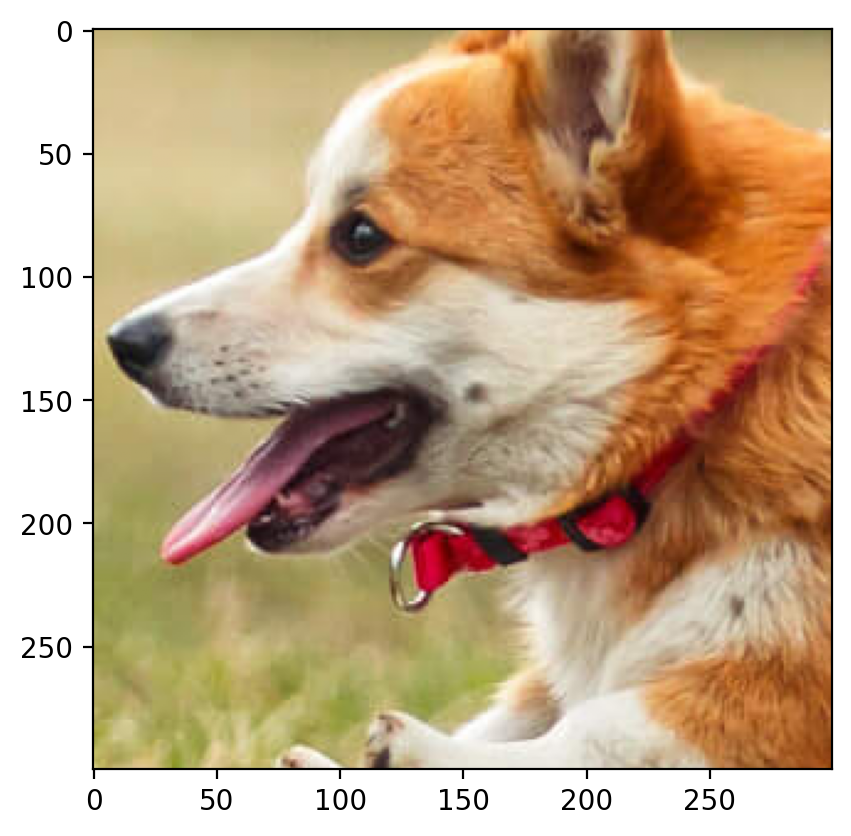

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [10]:
crop = crop.to(device)


In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [12]:
num_channels, height, width = 2, 3, 4

# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [13]:
X.shape

torch.Size([12, 2])

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [18]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

dog_X_scaled = scale_coordinates(dog_X)

In [19]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [20]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [21]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [22]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [23]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)


In [24]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [25]:
X_rff.shape

torch.Size([90000, 37500])

In [26]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff.to(device), dog_Y.to(device), 2500)

Epoch 0 loss: 0.375694
Epoch 100 loss: 0.048276
Epoch 200 loss: 0.009702
Epoch 300 loss: 0.004605
Epoch 400 loss: 0.002722
Epoch 500 loss: 0.001672
Epoch 600 loss: 0.001047
Epoch 700 loss: 0.000675
Epoch 800 loss: 0.000458
Epoch 900 loss: 0.000336
Epoch 1000 loss: 0.000270
Epoch 1100 loss: 0.000235
Epoch 1200 loss: 0.000218
Epoch 1300 loss: 0.000209
Epoch 1400 loss: 0.000205
Epoch 1500 loss: 0.000202
Epoch 1600 loss: 0.000201
Epoch 1700 loss: 0.000200
Epoch 1800 loss: 0.000199
Epoch 1900 loss: 0.000198
Epoch 2000 loss: 0.000198
Epoch 2100 loss: 0.000197
Epoch 2200 loss: 0.000197
Epoch 2300 loss: 0.000196
Epoch 2400 loss: 0.000196


0.0001957338972715661

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


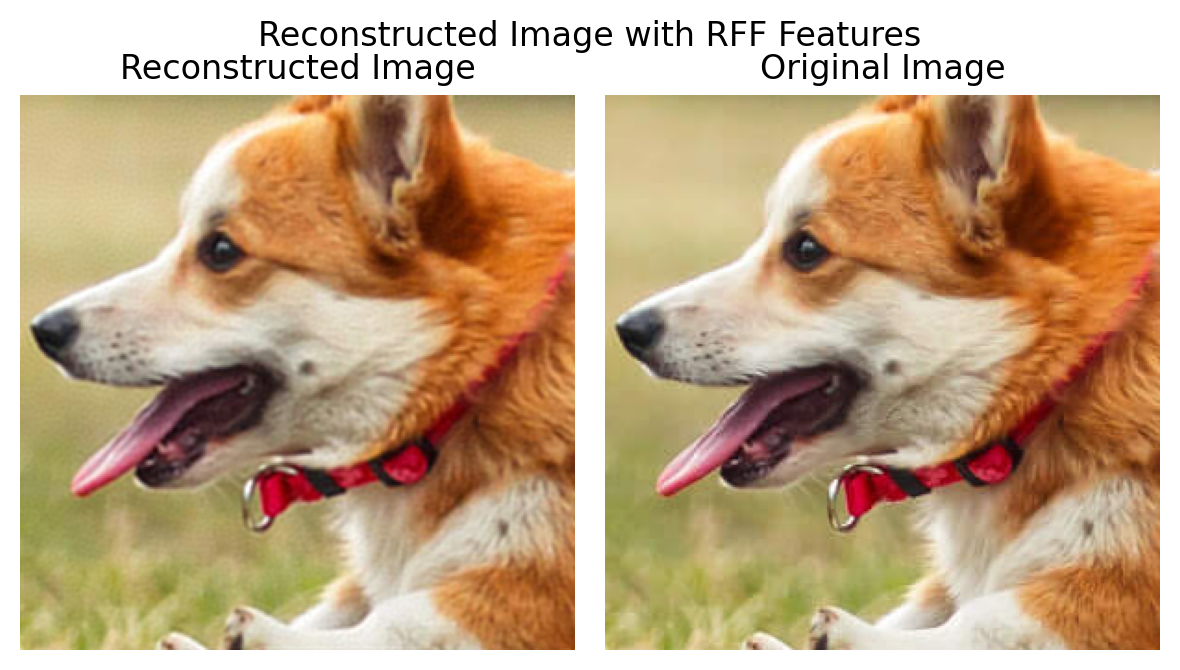

In [27]:
plot_reconstructed_and_original_image(crop.to(device), net, X_rff.to(device), title="Reconstructed Image with RFF Features")

In [28]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [29]:
create_coordinate_map(crop, scale=2)[0]


tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [299.5000, 298.5000],
        [299.5000, 299.0000],
        [299.5000, 299.5000]], device='cuda:0')

In [30]:
create_coordinate_map(crop, scale=1)[0]

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [299., 297.],
        [299., 298.],
        [299., 299.]], device='cuda:0')

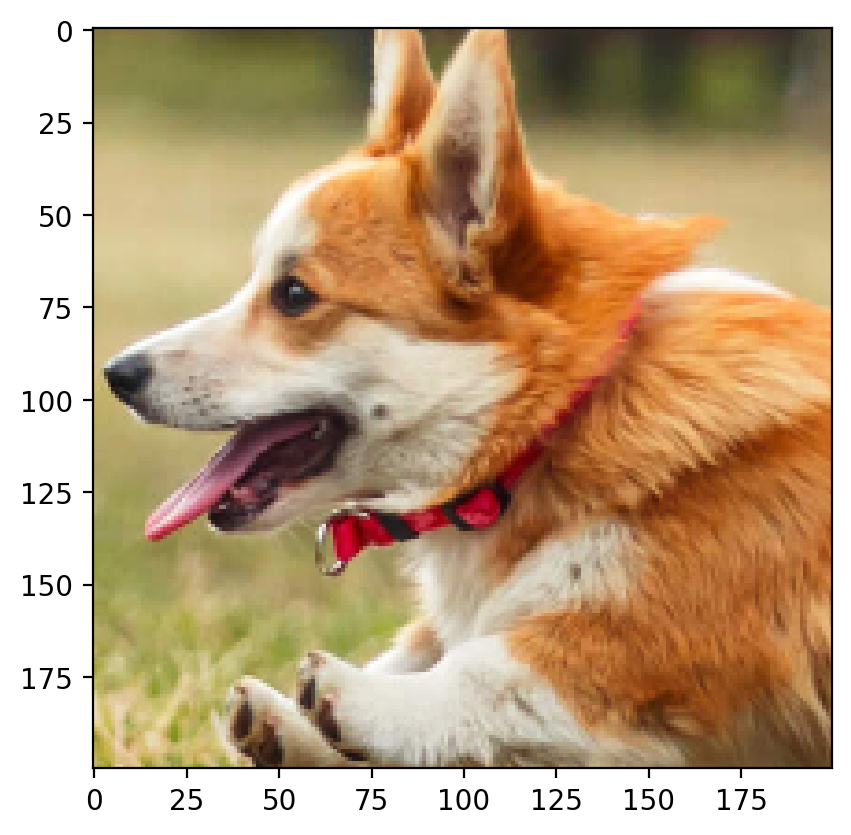

In [31]:
!pip install opencv-python
import cv2

crop_400 = crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 540, 800, 400, 400)

crop_400 = rearrange(crop_400, 'c h w -> h w c')

crop_400_downscaled = cv2.resize(crop_400.cpu().numpy(), (200, 200), interpolation=cv2.INTER_LINEAR)

plt.imshow(crop_400_downscaled)

In [32]:
def scale_coordinates(dog_X):        
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

    # Scale the X coordinates
    dog_X_scaled = scaler_X.transform(dog_X.cpu())

    # Move the scaled X coordinates to the GPU
    dog_X_scaled = torch.tensor(dog_X_scaled)

    # Set to dtype float32
    dog_X_scaled = dog_X_scaled.float()

    return dog_X_scaled

In [33]:
crop_downscaled_cmap, downscaled_RGB = create_coordinate_map(rearrange(torch.from_numpy(crop_400_downscaled), 'h w c -> c h w'))
crop_400_cmap, upscaled_RGB = create_coordinate_map(rearrange(crop_400 , 'h w c -> c h w'))

crop_downscaled_cmap = crop_downscaled_cmap * 2

crop_downscaled_cmap_scaled = scale_coordinates(crop_downscaled_cmap)

downscaled_RFF = create_rff_features(crop_downscaled_cmap_scaled, 25000, 0.008)

downscaled_RFF

crop_400_cmap_scaled = scale_coordinates(crop_400_cmap)

In [34]:
net = LinearModel(downscaled_RFF.shape[1], 3)
net.to(device)

train(net, 0.005, downscaled_RFF.to(device), downscaled_RGB.to(device), 2500)

Epoch 0 loss: 0.343494


Epoch 100 loss: 0.045833
Epoch 200 loss: 0.012530
Epoch 300 loss: 0.007349
Epoch 400 loss: 0.004946
Epoch 500 loss: 0.003450
Epoch 600 loss: 0.002467
Epoch 700 loss: 0.001803
Epoch 800 loss: 0.001345
Epoch 900 loss: 0.001026
Epoch 1000 loss: 0.000800
Epoch 1100 loss: 0.000639
Epoch 1200 loss: 0.000524
Epoch 1300 loss: 0.000442
Epoch 1400 loss: 0.000383
Epoch 1500 loss: 0.000340
Epoch 1600 loss: 0.000310
Epoch 1700 loss: 0.000289
Epoch 1800 loss: 0.000274
Epoch 1900 loss: 0.000263
Epoch 2000 loss: 0.000255
Epoch 2100 loss: 0.000250
Epoch 2200 loss: 0.000246
Epoch 2300 loss: 0.000244
Epoch 2400 loss: 0.000242


0.0002405649865977466

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


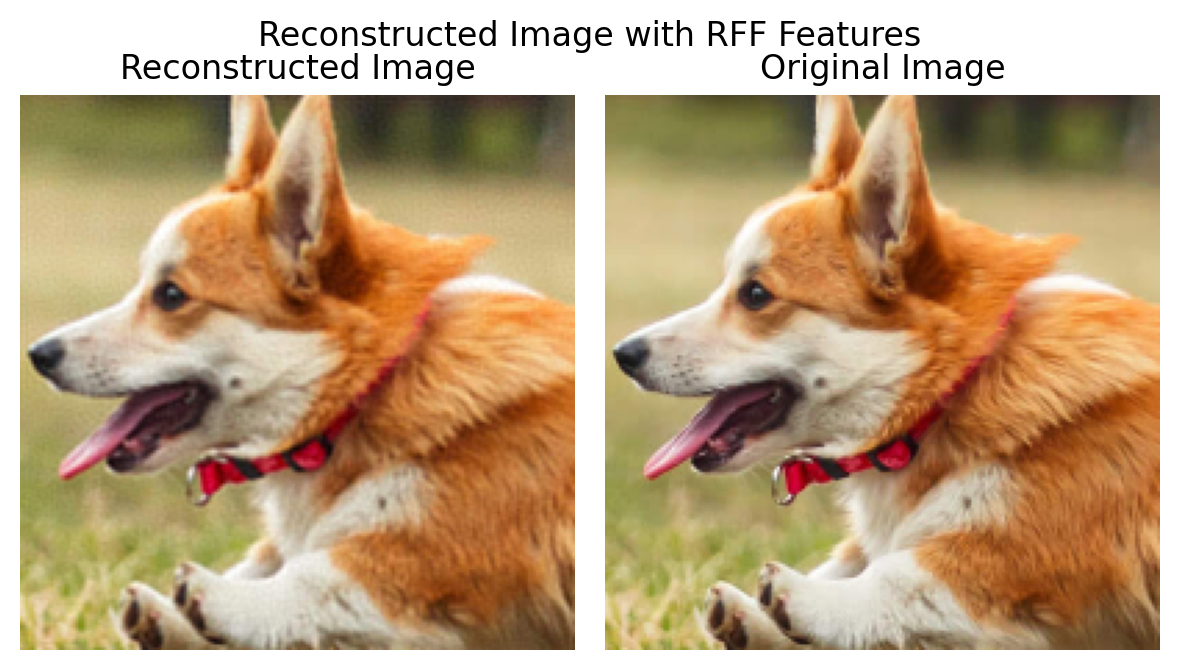

In [35]:
plot_reconstructed_and_original_image(torch.from_numpy(rearrange(crop_400_downscaled, 'h w c -> c h w')), net.cpu(), downscaled_RFF.cpu() , title="Reconstructed Image with RFF Features")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.0013, -0.0086,  0.0047,  ..., -0.0064,  0.0043,  0.0071],
        [ 0.0028, -0.0085,  0.0084,  ..., -0.0054, -0.0061,  0.0085],
        [ 0.0043, -0.0083,  0.0085,  ..., -0.0042, -0.0081,  0.0026],
        ...,
        [-0.0047,  0.0025,  0.0007,  ..., -0.0063,  0.0083,  0.0037],
        [-0.0032,  0.0030,  0.0060,  ..., -0.0052,  0.0057,  0.0088],
        [-0.0017,  0.0034,  0.0088,  ..., -0.0040, -0.0048,  0.0063]])

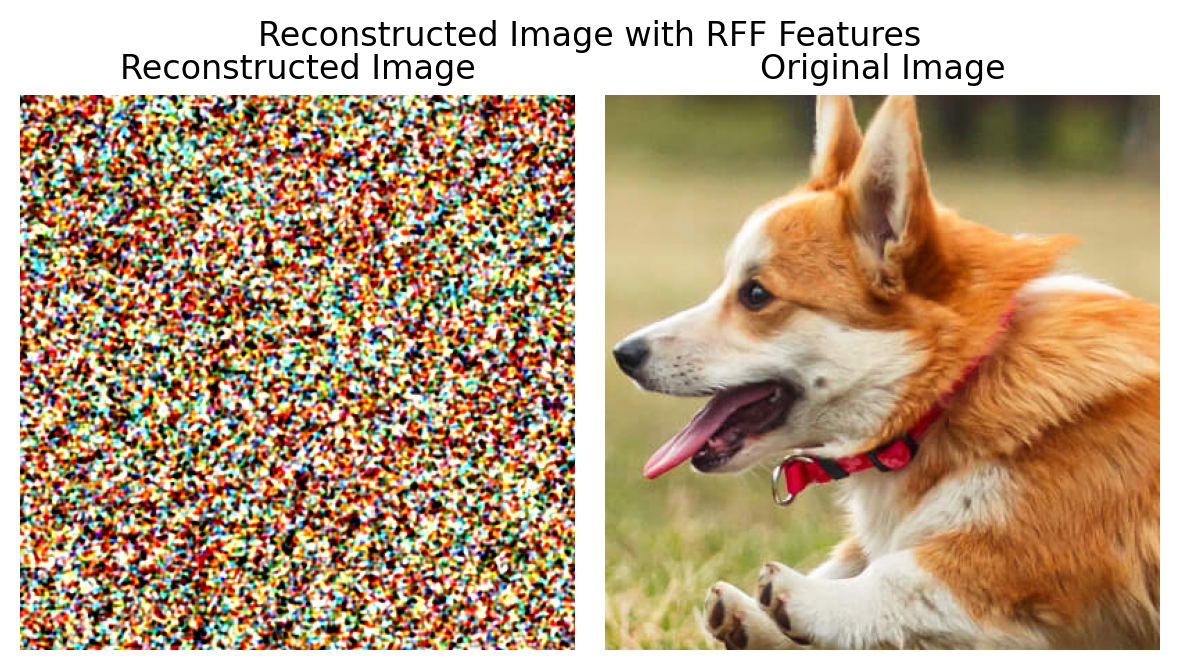

In [36]:
upscaled_RFF = create_rff_features(crop_400_cmap_scaled, 25000, 0.008)

plot_reconstructed_and_original_image(torch.from_numpy(rearrange(crop_400.numpy(), 'h w c -> c h w')), net.cpu(), upscaled_RFF.cpu() , title="Reconstructed Image with RFF Features")
upscaled_RFF

In [37]:
upscaled_RFF.shape

torch.Size([160000, 25000])

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn import preprocessing
import cv2
from einops import rearrange
from sklearn.kernel_approximation import RBFSampler
from torchvision.transforms.functional import crop

# Assuming CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_image(path, crop_size=400):
    img = torchvision.io.read_image(path)
    img_scaled = preprocessing.MinMaxScaler().fit_transform(img.reshape(-1, 1)).reshape(img.shape)
    img_scaled = torch.tensor(img_scaled)
    crop_img = crop(img_scaled, 540, 800, crop_size, crop_size)
    return crop_img

def resize_image(img, size):
    img = rearrange(img, 'c h w -> h w c')
    resized = cv2.resize(img.cpu().numpy(), size, interpolation=cv2.INTER_LINEAR)
    return torch.from_numpy(rearrange(resized, 'h w c -> c h w'))

def create_coordinate_map(img):
    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    X = torch.stack([h_coords.reshape(-1), w_coords.reshape(-1)], dim=1).float().to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float().to(device)
    return X, Y

def scale_coordinates(X):
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
    X_scaled = torch.tensor(scaler_X.transform(X.cpu()), dtype=torch.float32).to(device)
    return X_scaled

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X_rff = torch.tensor(rff.fit_transform(X.cpu().numpy()), dtype=torch.float32).to(device)
    return X_rff

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train_model(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def predict_image(net, X):
    net.eval()
    with torch.no_grad():
        return net(X)

def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return rmse.item(), psnr.item()

def plot_images(original, downscaled, predicted, title=""):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(rearrange(original, 'c h w -> h w c').cpu().numpy())
    axs[0].set_title("Original")
    axs[1].imshow(rearrange(downscaled, 'c h w -> h w c').cpu().numpy())
    axs[1].set_title("Downscaled")
    axs[2].imshow(rearrange(predicted, 'c h w -> h w c').cpu().numpy())
    axs[2].set_title("Predicted")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Main execution
img_path = "dog.jpg"  # Make sure this path is correct
original_img = load_and_preprocess_image(img_path)
downscaled_img = resize_image(original_img, (200, 200))

# Prepare data for training (200x200)
X_down, Y_down = create_coordinate_map(downscaled_img)
X_down_scaled = scale_coordinates(X_down)
X_down_rff = create_rff_features(X_down_scaled, 20000, 0.008)

# Train model
net = LinearModel(X_down_rff.shape[1], 3).to(device)
train_model(net, 0.005, X_down_rff, Y_down, 2500)

# Prepare data for prediction (400x400)


Epoch 0 loss: 0.341210
Epoch 100 loss: 0.048611
Epoch 200 loss: 0.013310
Epoch 300 loss: 0.007668


Epoch 400 loss: 0.005152
Epoch 500 loss: 0.003593
Epoch 600 loss: 0.002557
Epoch 700 loss: 0.001849
Epoch 800 loss: 0.001359
Epoch 900 loss: 0.001021
Epoch 1000 loss: 0.000789
Epoch 1100 loss: 0.000631
Epoch 1200 loss: 0.000525
Epoch 1300 loss: 0.000455
Epoch 1400 loss: 0.000409
Epoch 1500 loss: 0.000379
Epoch 1600 loss: 0.000359
Epoch 1700 loss: 0.000346
Epoch 1800 loss: 0.000338
Epoch 1900 loss: 0.000332
Epoch 2000 loss: 0.000328
Epoch 2100 loss: 0.000325
Epoch 2200 loss: 0.000322
Epoch 2300 loss: 0.000320
Epoch 2400 loss: 0.000318


0.0003169941483065486

In [47]:
X_up, Y_up = create_coordinate_map(original_img)
X_up_scaled = scale_coordinates(X_up)
print("*")
X_up_rff = create_rff_features(X_up_scaled.cpu(), 20000, 0.008)

# Predict high-resolution image
predicted_img = predict_image(net, X_up_rff).reshape(original_img.shape)

# Calculate metrics
rmse, psnr = calculate_metrics(original_img, predicted_img)
print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.4f} dB")

# Plot results
plot_images(original_img, downscaled_img, predicted_img, "Super-Resolution Results")

*


OutOfMemoryError: CUDA out of memory. Tried to allocate 11.92 GiB. GPU 0 has a total capacity of 22.17 GiB of which 9.26 GiB is free. Process 427834 has 12.91 GiB memory in use. Of the allocated memory 3.07 GiB is allocated by PyTorch, and 9.61 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)